In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro
from statsmodels.graphics.gofplots import qqplot

warnings.filterwarnings("ignore")


In this notebook, I will explor and compare different regression models, including Linear Regression, Polynomial Regression, and regularized models like Ridge and Lasso, to predict the selling price of a dataset, while evaluating their performance based on key metrics such as MAE, MSE, RMSE, and R2 score.

In [57]:
data = pd.read_csv('/content/drive/MyDrive/Econometrics Mini Project/car data.csv')

1- Preprocessing and Cleaning

In [58]:
data.shape
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


In [59]:
data.isna().sum()

,0
Car_Name,0
Year,0
Selling_Price,0
Present_Price,0
Kms_Driven,0
Fuel_Type,0
Seller_Type,0
Transmission,0
Owner,0


In [60]:
data["Year"]

,Year
0,2014
1,2013
2,2017
3,2011
4,2014
...,...
296,2016
297,2015
298,2009
299,2017


In [61]:
np.max(data["Year"])

2018

In [62]:
data["Age"] = 2019 - data["Year"]

In [63]:
data.drop("Year" , axis = 1 , inplace = True)
data

,Car_Name,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Age
0,ritz,3.35,5.59,27000,Petrol,Dealer,Manual,0,5
1,sx4,4.75,9.54,43000,Diesel,Dealer,Manual,0,6
2,ciaz,7.25,9.85,6900,Petrol,Dealer,Manual,0,2
3,wagon r,2.85,4.15,5200,Petrol,Dealer,Manual,0,8
4,swift,4.60,6.87,42450,Diesel,Dealer,Manual,0,5
...,...,...,...,...,...,...,...,...,...
296,city,9.50,11.60,33988,Diesel,Dealer,Manual,0,3
297,brio,4.00,5.90,60000,Petrol,Dealer,Manual,0,4
298,city,3.35,11.00,87934,Petrol,Dealer,Manual,0,10
299,city,11.50,12.50,9000,Diesel,Dealer,Manual,0,2


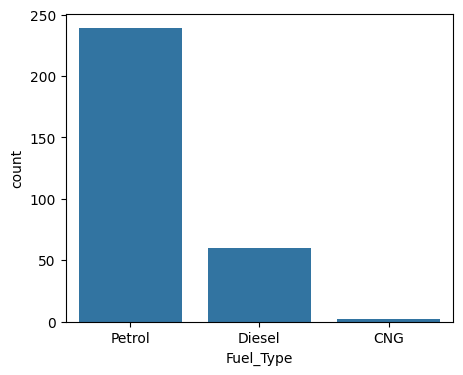

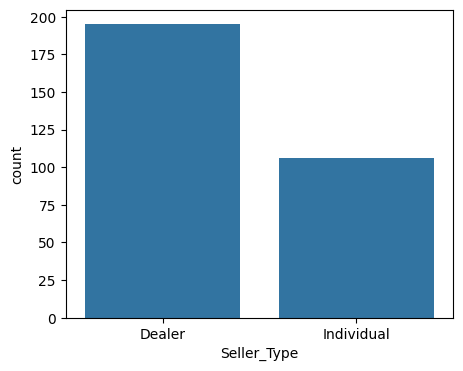

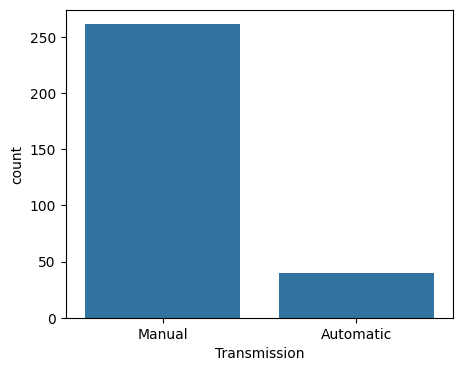

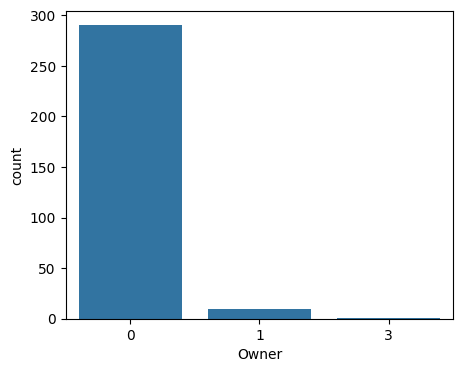

In [64]:
columns = ["Fuel_Type","Seller_Type","Transmission","Owner"]
for i in columns:
    fig = plt.figure(figsize =[5,4])
    sns.countplot(x=i, data=data)
    plt.xlabel(i)
    plt.show()

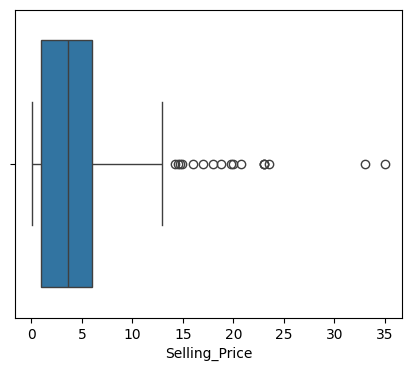

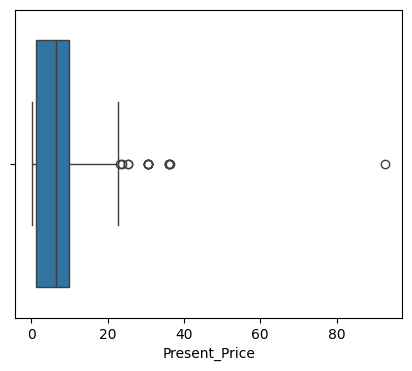

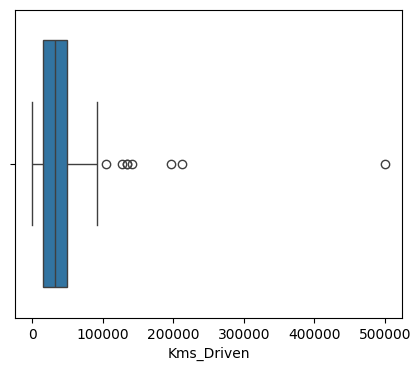

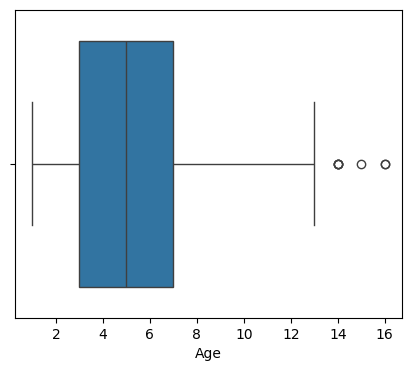

In [65]:
columns = ["Selling_Price","Present_Price","Kms_Driven","Age"]
for i in columns:
    fig = plt.figure(figsize =[5,4])
    sns.boxplot(x=i, data=data)
    plt.xlabel(i)
    plt.show()

In [66]:
numeric_data = data.select_dtypes(include=["number"])
numeric_data

,Selling_Price,Present_Price,Kms_Driven,Owner,Age
0,3.35,5.59,27000,0,5
1,4.75,9.54,43000,0,6
2,7.25,9.85,6900,0,2
3,2.85,4.15,5200,0,8
4,4.60,6.87,42450,0,5
...,...,...,...,...,...
296,9.50,11.60,33988,0,3
297,4.00,5.90,60000,0,4
298,3.35,11.00,87934,0,10
299,11.50,12.50,9000,0,2


In [67]:
numeric_data.corr()

,Selling_Price,Present_Price,Kms_Driven,Owner,Age
Selling_Price,1.000000,0.878983,0.029187,-0.088344,-0.236141
Present_Price,0.878983,1.000000,0.203647,0.008057,0.047584
Kms_Driven,0.029187,0.203647,1.000000,0.089216,0.524342
Owner,-0.088344,0.008057,0.089216,1.000000,0.182104
Age,-0.236141,0.047584,0.524342,0.182104,1.000000


In [68]:
print(pd.unique(data["Fuel_Type"]))
print(pd.unique(data["Seller_Type"]))
print(pd.unique(data["Transmission"]))
print(pd.unique(data["Owner"]))

['Petrol' 'Diesel' 'CNG']
['Dealer' 'Individual']
['Manual' 'Automatic']
[0 1 3]


In [69]:
data["Fuel_Type"].replace({"Petrol":2 , "Diesel":3 , "CNG":4} , inplace=True)
data["Seller_Type"].replace({"Dealer":2 , "Individual":3 } , inplace=True)
data["Transmission"].replace({"Manual":2 , "Automatic":3 } , inplace=True)
data

,Car_Name,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Age
0,ritz,3.35,5.59,27000,2,2,2,0,5
1,sx4,4.75,9.54,43000,3,2,2,0,6
2,ciaz,7.25,9.85,6900,2,2,2,0,2
3,wagon r,2.85,4.15,5200,2,2,2,0,8
4,swift,4.60,6.87,42450,3,2,2,0,5
...,...,...,...,...,...,...,...,...,...
296,city,9.50,11.60,33988,3,2,2,0,3
297,brio,4.00,5.90,60000,2,2,2,0,4
298,city,3.35,11.00,87934,2,2,2,0,10
299,city,11.50,12.50,9000,3,2,2,0,2


In [70]:
data.drop(labels="Car_Name" , axis =1 , inplace = True)
data

,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Age
0,3.35,5.59,27000,2,2,2,0,5
1,4.75,9.54,43000,3,2,2,0,6
2,7.25,9.85,6900,2,2,2,0,2
3,2.85,4.15,5200,2,2,2,0,8
4,4.60,6.87,42450,3,2,2,0,5
...,...,...,...,...,...,...,...,...
296,9.50,11.60,33988,3,2,2,0,3
297,4.00,5.90,60000,2,2,2,0,4
298,3.35,11.00,87934,2,2,2,0,10
299,11.50,12.50,9000,3,2,2,0,2


2- EDA

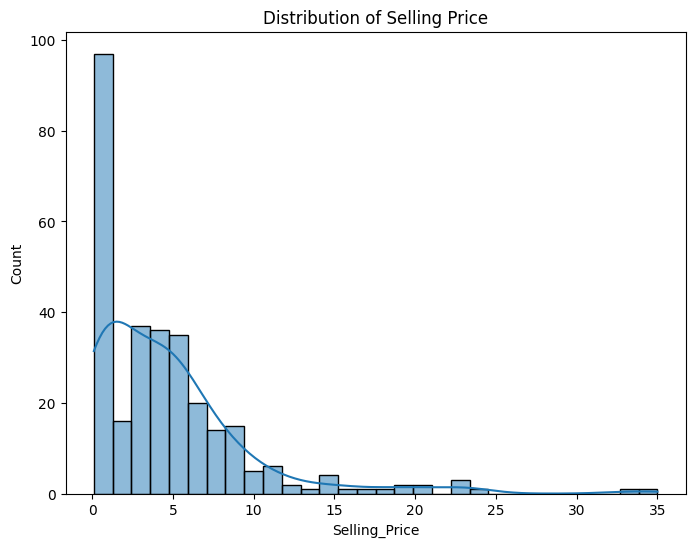

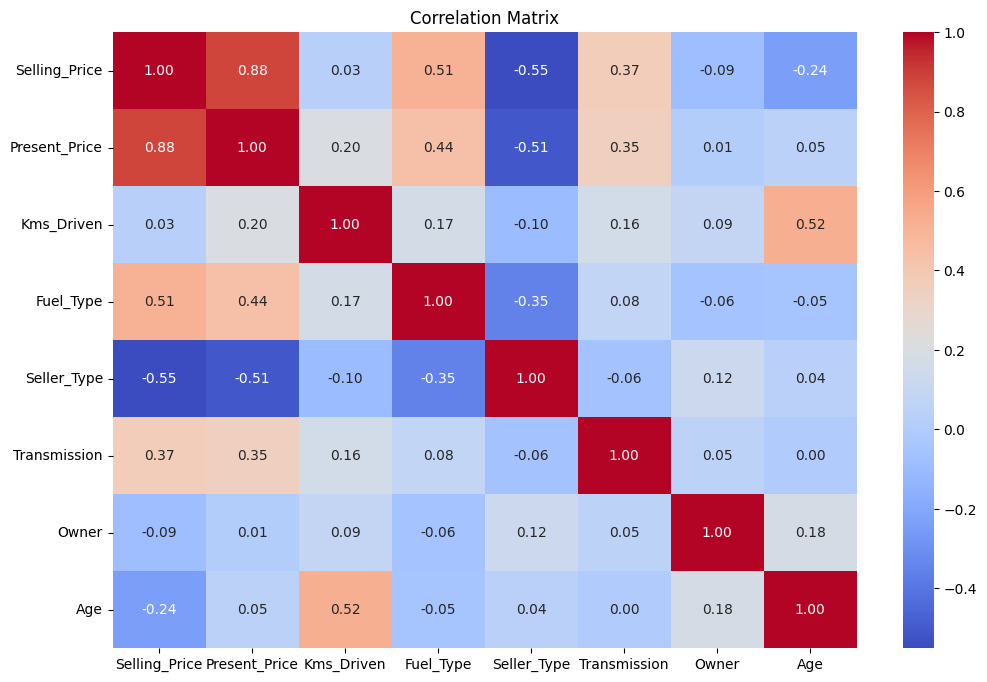

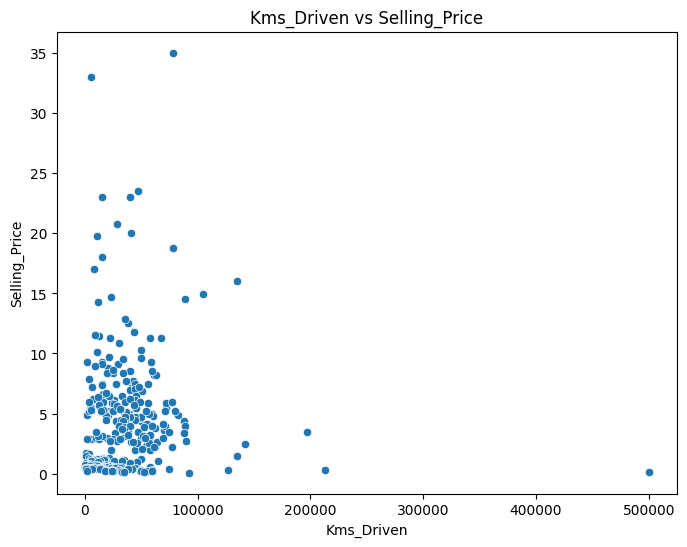

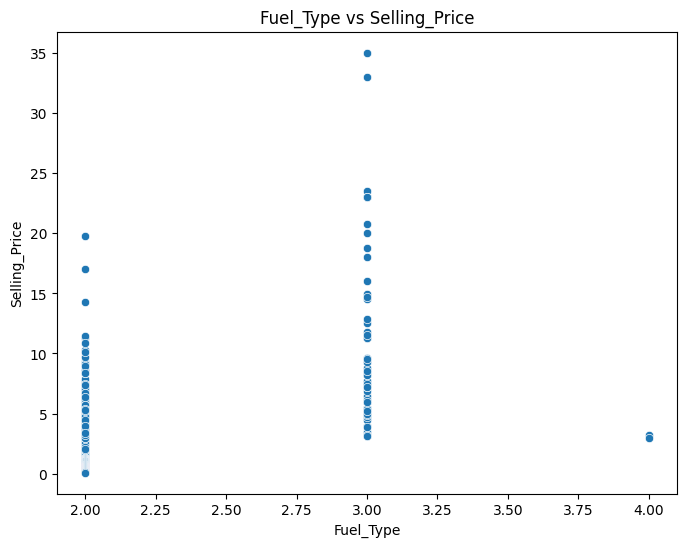

In [71]:
# Plot distribution of Popularity (target variable)
plt.figure(figsize=(8, 6))
sns.histplot(data['Selling_Price'], kde=True, bins=30)
plt.title('Distribution of Selling Price')
plt.show()

# Correlation Matrix (numerical features vs target)
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Scatter plot of some features vs Popularity
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['Kms_Driven'], y=data['Selling_Price'])
plt.title('Kms_Driven vs Selling_Price')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['Fuel_Type'], y=data['Selling_Price'])
plt.title('Fuel_Type vs Selling_Price')
plt.show()

3- Regression

In [72]:
x = data.drop ("Selling_Price" , axis =1)
y = data["Selling_Price"]

In [54]:
x_train,x_test ,y_train, y_test = train_test_split(x ,y,test_size = 0.2, random_state =1)
print("x_train: ",x_train.shape)
print("x_test: ",x_test.shape)
print("y_test: ",y_test.shape)
print("y_train: ",y_train.shape)

x_train:  (240, 7)
x_test:  (61, 7)
y_test:  (61,)
y_train:  (240,)


In [55]:
Model = LinearRegression()
Model.fit (x_train, y_train)

LinearRegression()

In [56]:
y_pred = Model.predict(x_test)
print("Mean Absolute Error: ", metrics.mean_absolute_error(y_test,y_pred))
print("Mean Squared Error: " , metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: " ,np.sqrt(metrics.mean_squared_error(y_test,y_pred)))
print("R2 Score: ", metrics.r2_score(y_test,y_pred))

Mean Absolute Error:  1.153004591615891
Mean Squared Error:  3.2876460857158327
Root Mean Squared Error:  1.8131867211392854
R2 Score:  0.8484549412090382


Multicollinearity Checks

In [83]:
# Variance Inflation Factor (VIF) to check multicollinearity
X = data.drop('Selling_Price', axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

         feature        VIF
0  Present_Price   3.160360
1     Kms_Driven   2.803427
2      Fuel_Type  22.175793
3    Seller_Type  25.341923
4   Transmission  33.444362
5          Owner   1.079765
6            Age   6.159567


In [84]:
# Drop variables with high VIF
columns_to_drop = ['Transmission']
X = X.drop(columns=columns_to_drop)

# Re-calculate VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

         feature        VIF
0  Present_Price   2.686853
1     Kms_Driven   2.790218
2      Fuel_Type  18.404365
3    Seller_Type  15.089987
4          Owner   1.079281
5            Age   6.152168


4- CLI Assumptions check

Mean of residuals: -0.25046345939087045


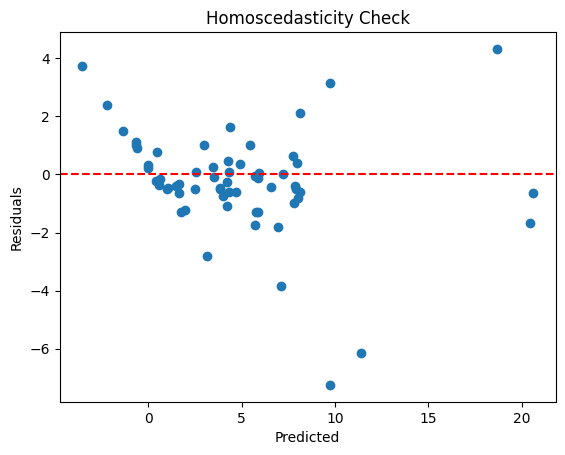

Durbin-Watson statistic: 1.6357637290566582
Shapiro-Wilk test p-value: 7.819458469143315e-06


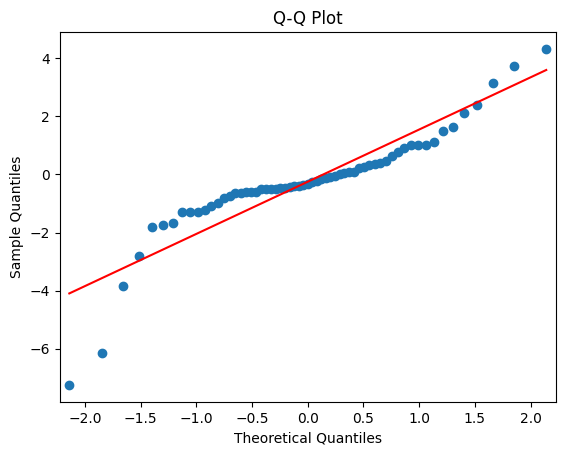

In [85]:
# Calculate residuals
residuals = y_test - y_pred
print(f"Mean of residuals: {residuals.mean()}")  # Should be close to 0

## Homoscedasticity (Constant variance of errors)
plt.scatter(y_pred, residuals)
plt.axhline(0, color='r', linestyle='--')
plt.title('Homoscedasticity Check')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.show()

## No Autocorrelation (Durbin-Watson test)
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw_stat}")

## No Multicollinearity (Already dealt with)

## Normality of Errors (Shapiro-Wilk test and Q-Q plot)
stat, p_value = shapiro(residuals)
print(f"Shapiro-Wilk test p-value: {p_value}")
qqplot(residuals, line='s')
plt.title('Q-Q Plot')
plt.show()

In [87]:
# Re-split the data after dropping the 'Transmission' column
X = data.drop("Selling_Price", axis=1)
X = X.drop(columns=columns_to_drop)  # Drop the 'Transmission' column from the features

# Re-split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print("x_train: ", X_train.shape)
print("x_test: ", X_test.shape)
print("y_test: ", y_test.shape)
print("y_train: ", y_train.shape)

# Initialize and fit the model again
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Display evaluation metrics
print("Mean Absolute Error: ", metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error: ", metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2 Score: ", metrics.r2_score(y_test, y_pred))


x_train:  (240, 6)
x_test:  (61, 6)
y_test:  (61,)
y_train:  (240,)
Mean Absolute Error:  1.1075595770476743
Mean Squared Error:  2.7889653983066283
Root Mean Squared Error:  1.6700195802165398
R2 Score:  0.8714417810698409


In [88]:
# Recalculate VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)


         feature        VIF
0  Present_Price   2.686853
1     Kms_Driven   2.790218
2      Fuel_Type  18.404365
3    Seller_Type  15.089987
4          Owner   1.079281
5            Age   6.152168


Mean of residuals: -0.11908094046259796


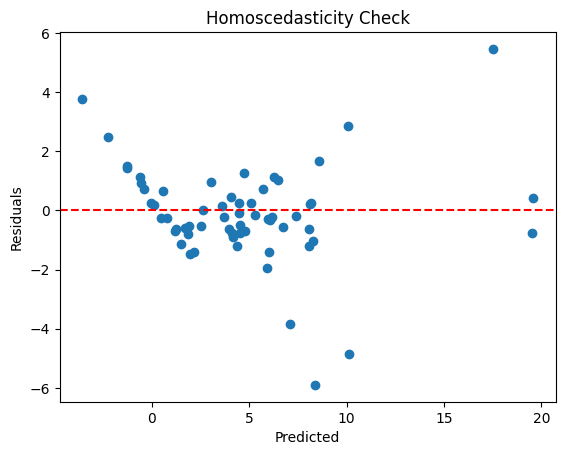

Durbin-Watson statistic: 1.676718087805014
Shapiro-Wilk test p-value: 5.547730124060546e-05


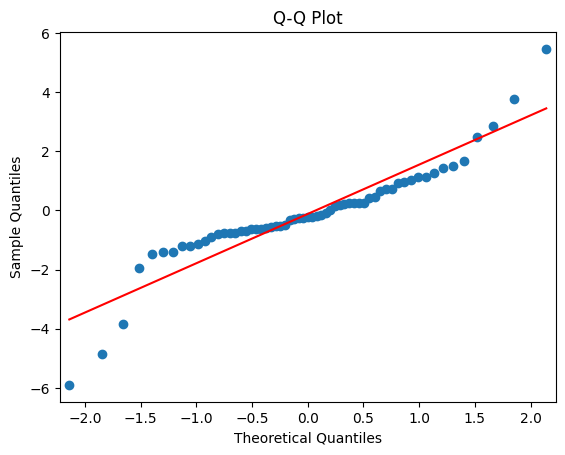

In [89]:
# Calculate residuals
residuals = y_test - y_pred
print(f"Mean of residuals: {residuals.mean()}")  # Should be close to 0

# Homoscedasticity check (Constant variance of errors)
plt.scatter(y_pred, residuals)
plt.axhline(0, color='r', linestyle='--')
plt.title('Homoscedasticity Check')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.show()

# Durbin-Watson test for autocorrelation
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw_stat}")

# Shapiro-Wilk test for normality
stat, p_value = shapiro(residuals)
print(f"Shapiro-Wilk test p-value: {p_value}")
qqplot(residuals, line='s')
plt.title('Q-Q Plot')
plt.show()


5- Comparing different regression models

                        Model       MAE       MSE      RMSE  R2 Score
0           Linear Regression  1.153005  3.287646  1.813187  0.848455
1  Multiple Linear Regression  1.153005  3.287646  1.813187  0.848455
2       Polynomial Regression  0.723500  2.842669  1.686022  0.868966


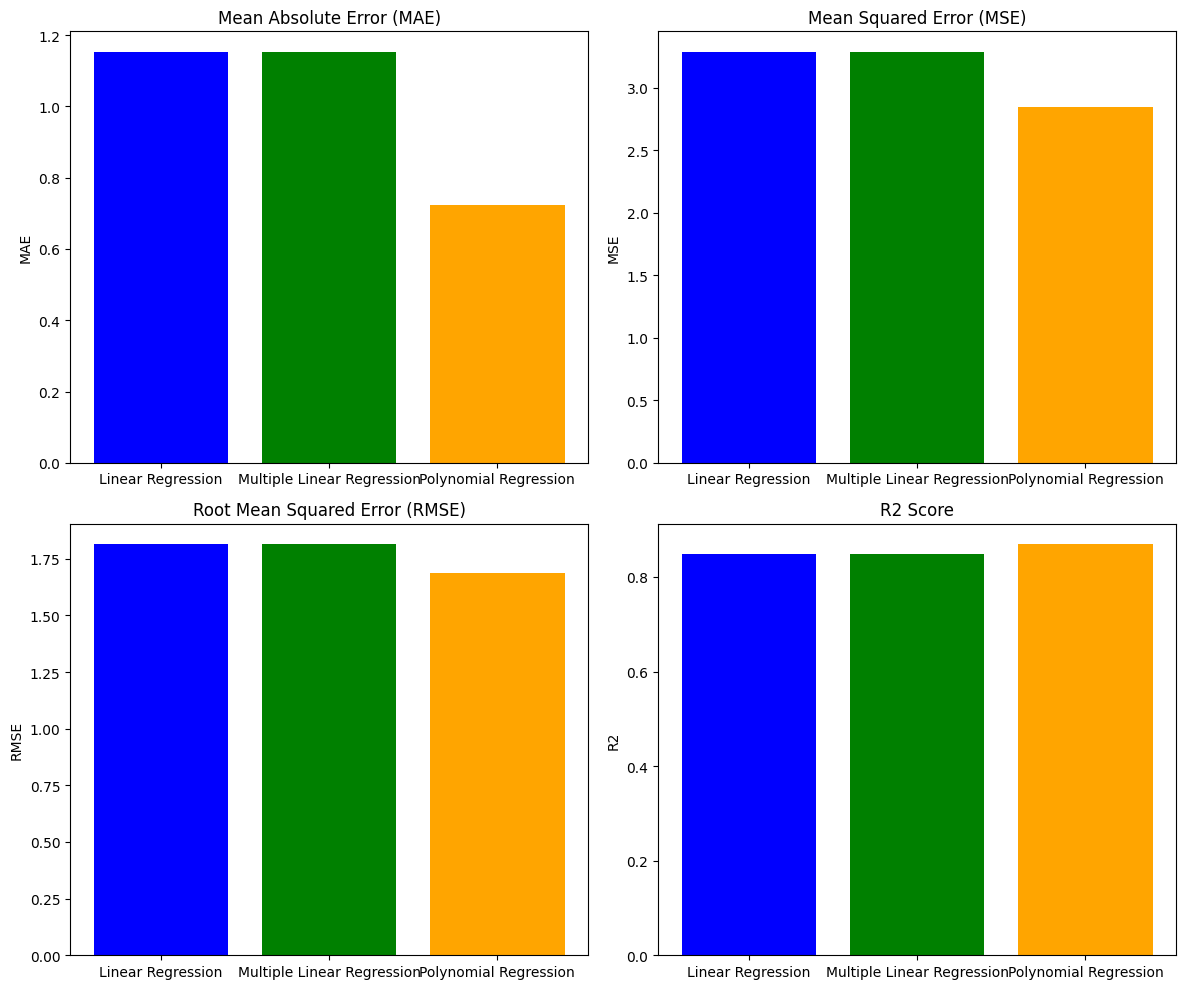

In [91]:
# Prepare data
X = data.drop('Selling_Price', axis=1)
y = data['Selling_Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# 1. Initial Linear Regression Model (as a baseline)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# 2. Multiple Linear Regression (same as Initial Linear Regression here)
# This is essentially just Linear Regression with multiple features already used, so it's similar.
multi_lr_model = LinearRegression()
multi_lr_model.fit(X_train, y_train)
y_pred_multi_lr = multi_lr_model.predict(X_test)

# 3. Polynomial Regression (with degree 2)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
y_pred_poly = poly_model.predict(X_test_poly)

# Calculate metrics for all three models

# Linear Regression Metrics
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Multiple Linear Regression Metrics
mae_multi_lr = mean_absolute_error(y_test, y_pred_multi_lr)
mse_multi_lr = mean_squared_error(y_test, y_pred_multi_lr)
rmse_multi_lr = np.sqrt(mse_multi_lr)
r2_multi_lr = r2_score(y_test, y_pred_multi_lr)

# Polynomial Regression Metrics
mae_poly = mean_absolute_error(y_test, y_pred_poly)
mse_poly = mean_squared_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)
r2_poly = r2_score(y_test, y_pred_poly)

# Collecting all metrics in a DataFrame
metrics_data = {
    'Model': ['Linear Regression', 'Multiple Linear Regression', 'Polynomial Regression'],
    'MAE': [mae_lr, mae_multi_lr, mae_poly],
    'MSE': [mse_lr, mse_multi_lr, mse_poly],
    'RMSE': [rmse_lr, rmse_multi_lr, rmse_poly],
    'R2 Score': [r2_lr, r2_multi_lr, r2_poly]
}

metrics_df = pd.DataFrame(metrics_data)
print(metrics_df)

# Plotting the comparison of models
models = ['Linear Regression', 'Multiple Linear Regression', 'Polynomial Regression']
mae_values = [mae_lr, mae_multi_lr, mae_poly]
mse_values = [mse_lr, mse_multi_lr, mse_poly]
rmse_values = [rmse_lr, rmse_multi_lr, rmse_poly]
r2_values = [r2_lr, r2_multi_lr, r2_poly]

fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Plotting MAE Comparison
ax[0, 0].bar(models, mae_values, color=['blue', 'green', 'orange'])
ax[0, 0].set_title('Mean Absolute Error (MAE)')
ax[0, 0].set_ylabel('MAE')

# Plotting MSE Comparison
ax[0, 1].bar(models, mse_values, color=['blue', 'green', 'orange'])
ax[0, 1].set_title('Mean Squared Error (MSE)')
ax[0, 1].set_ylabel('MSE')

# Plotting RMSE Comparison
ax[1, 0].bar(models, rmse_values, color=['blue', 'green', 'orange'])
ax[1, 0].set_title('Root Mean Squared Error (RMSE)')
ax[1, 0].set_ylabel('RMSE')

# Plotting R2 Score Comparison
ax[1, 1].bar(models, r2_values, color=['blue', 'green', 'orange'])
ax[1, 1].set_title('R2 Score')
ax[1, 1].set_ylabel('R2')

plt.tight_layout()
plt.show()


Model Comparison:

1.   Linear Regression & Multiple Linear

MAE: 1.153 (fairly high error on average)

MSE: 3.288

RMSE: 1.813 (a bit high, indicating the presence of significant error)

R² Score: 0.848 (good, indicating that the model explains about 84.8% of the variance)

2.   Polynomial Regression:

MAE: 0.723 (lower, which means better performance in terms of average error)

MSE: 2.843 (lower, which means the errors are smaller on average)

RMSE: 1.686 (lower, indicating better fit)

R² Score: 0.869 (better than linear regression, explaining 86.9% of the variance)

                              Model       MAE          MSE       RMSE  \
0  Polynomial Regression (Degree 3)  1.865700    36.691106   6.057318   
1  Polynomial Regression (Degree 4)  4.762968   461.000754  21.470928   
2       Ridge Regression (Degree 3)  6.151940  1952.064499  44.182174   
3       Lasso Regression (Degree 3)  3.090780   401.635648  20.040849   

    R2 Score  
0  -0.691288  
1 -20.249972  
2 -88.981014  
3 -17.513519  


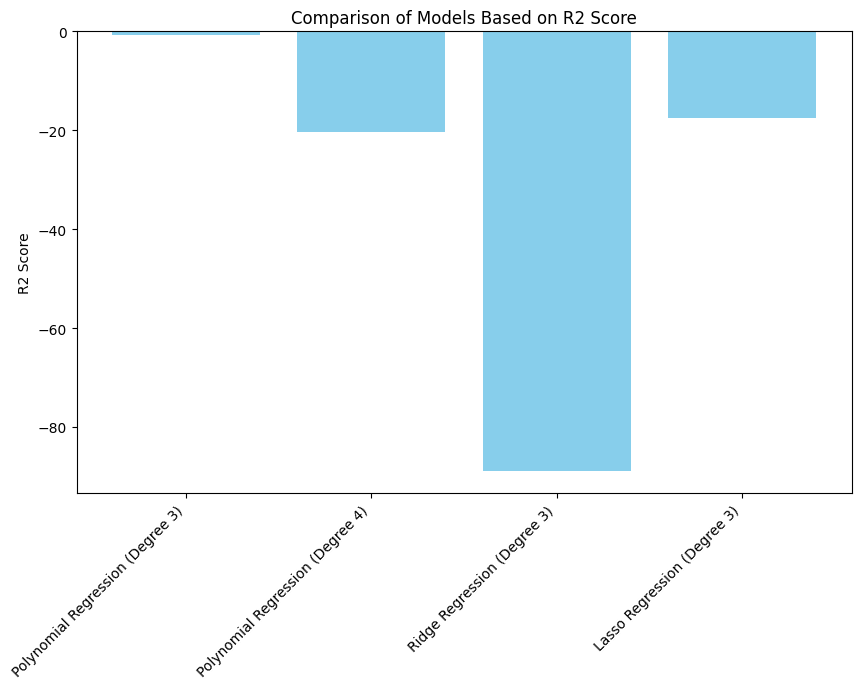

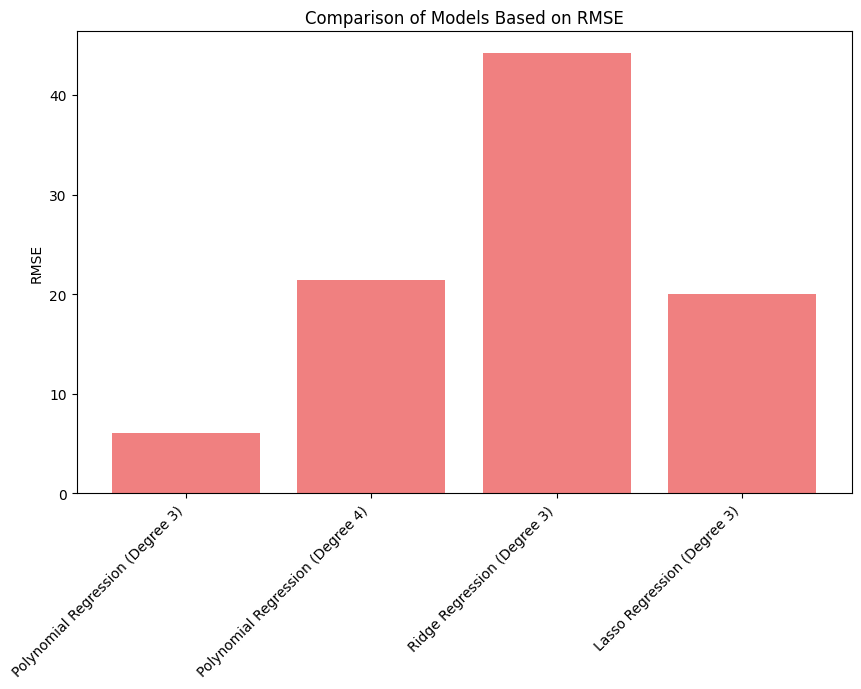

In [92]:
# Step 1: Higher-degree Polynomial Regression (degree 3 and 4)
# Polynomial degree 3
poly_features_3 = PolynomialFeatures(degree=3)
X_poly_3 = poly_features_3.fit_transform(x_train)

# Polynomial Regression with degree 3
poly_model_3 = LinearRegression()
poly_model_3.fit(X_poly_3, y_train)
y_pred_poly_3 = poly_model_3.predict(poly_features_3.transform(x_test))

# Polynomial degree 4
poly_features_4 = PolynomialFeatures(degree=4)
X_poly_4 = poly_features_4.fit_transform(x_train)

# Polynomial Regression with degree 4
poly_model_4 = LinearRegression()
poly_model_4.fit(X_poly_4, y_train)
y_pred_poly_4 = poly_model_4.predict(poly_features_4.transform(x_test))

# Step 2: Apply Ridge and Lasso Regression to polynomial features

# Ridge Regression (with degree 3 polynomial)
ridge_model = Ridge(alpha=1.0)  # Alpha is the regularization parameter
ridge_model.fit(X_poly_3, y_train)
y_pred_ridge = ridge_model.predict(poly_features_3.transform(x_test))

# Lasso Regression (with degree 3 polynomial)
lasso_model = Lasso(alpha=0.01)  # Alpha is the regularization parameter
lasso_model.fit(X_poly_3, y_train)
y_pred_lasso = lasso_model.predict(poly_features_3.transform(x_test))

# Step 3: Evaluate all models with the same metrics (MAE, MSE, RMSE, R2)
models = [
    ("Polynomial Regression (Degree 3)", y_pred_poly_3),
    ("Polynomial Regression (Degree 4)", y_pred_poly_4),
    ("Ridge Regression (Degree 3)", y_pred_ridge),
    ("Lasso Regression (Degree 3)", y_pred_lasso)
]

# Store the results in a list for comparison
results = []

for model_name, y_pred in models:
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results.append([model_name, mae, mse, rmse, r2])

# Display the results in a DataFrame
import pandas as pd
results_df = pd.DataFrame(results, columns=["Model", "MAE", "MSE", "RMSE", "R2 Score"])
print(results_df)

# Step 4: Plot comparison of models based on R2 score
plt.figure(figsize=(10, 6))
plt.bar(results_df["Model"], results_df["R2 Score"], color='skyblue')
plt.title("Comparison of Models Based on R2 Score")
plt.ylabel("R2 Score")
plt.xticks(rotation=45, ha='right')
plt.show()

# Step 5: Plot comparison of models based on RMSE
plt.figure(figsize=(10, 6))
plt.bar(results_df["Model"], results_df["RMSE"], color='lightcoral')
plt.title("Comparison of Models Based on RMSE")
plt.ylabel("RMSE")
plt.xticks(rotation=45, ha='right')
plt.show()


Polynomial Regression (Degree 3):

MAE: 1.87
MSE: 36.69
RMSE: 6.06
R² Score: -0.69
Analysis: This model is performing poorly because the R² score is negative, indicating that the model is worse than just predicting the mean of the target variable. This suggests that the model is overfitting, possibly due to a too-high polynomial degree (or a lack of sufficient data).

Polynomial Regression (Degree 4):

MAE: 4.76
MSE: 461.00
RMSE: 21.47
R² Score: -20.25
Analysis: This model is also overfitting badly. The large values for MAE, MSE, RMSE, and the very negative R² score suggest that the degree 4 polynomial introduces too much complexity for the given data, leading to a poor model.

Ridge Regression (Degree 3):

MAE: 6.15
MSE: 1952.06
RMSE: 44.18
R² Score: -88.98
Analysis: Ridge regression applied on the polynomial features with degree 3 performs very poorly, with a very high RMSE and an extremely negative R² score. This suggests overfitting and that the regularization is not sufficient to handle the complexity introduced by the polynomial features.

Lasso Regression (Degree 3):

MAE: 3.09
MSE: 401.64
RMSE: 20.04
R² Score: -17.51
Analysis: Lasso also suffers from overfitting with a negative R² score, though its performance is slightly better than Ridge. The Lasso model has a smaller RMSE compared to Ridge, but it still has significant issues.

In [93]:
# Polynomial Regression with degree 2
poly2 = PolynomialFeatures(degree=2)
X_poly2 = poly2.fit_transform(x_train)
X_test_poly2 = poly2.transform(x_test)

model_poly2 = LinearRegression()
model_poly2.fit(X_poly2, y_train)
y_pred_poly2 = model_poly2.predict(X_test_poly2)

# Polynomial Regression with degree 3
poly3 = PolynomialFeatures(degree=3)
X_poly3 = poly3.fit_transform(x_train)
X_test_poly3 = poly3.transform(x_test)

model_poly3 = LinearRegression()
model_poly3.fit(X_poly3, y_train)
y_pred_poly3 = model_poly3.predict(X_test_poly3)

# Calculate metrics for Polynomial Regression (Degree 2)
mae_poly2 = mean_absolute_error(y_test, y_pred_poly2)
mse_poly2 = mean_squared_error(y_test, y_pred_poly2)
rmse_poly2 = np.sqrt(mse_poly2)
r2_poly2 = r2_score(y_test, y_pred_poly2)

# Calculate metrics for Polynomial Regression (Degree 3)
mae_poly3 = mean_absolute_error(y_test, y_pred_poly3)
mse_poly3 = mean_squared_error(y_test, y_pred_poly3)
rmse_poly3 = np.sqrt(mse_poly3)
r2_poly3 = r2_score(y_test, y_pred_poly3)

# Displaying results
print(f"Polynomial Regression (Degree 2) - MAE: {mae_poly2}, MSE: {mse_poly2}, RMSE: {rmse_poly2}, R2: {r2_poly2}")
print(f"Polynomial Regression (Degree 3) - MAE: {mae_poly3}, MSE: {mse_poly3}, RMSE: {rmse_poly3}, R2: {r2_poly3}")


Polynomial Regression (Degree 2) - MAE: 0.7235001755349708, MSE: 2.8426692706971854, RMSE: 1.6860217290109833, R2: 0.8689662845332491
Polynomial Regression (Degree 3) - MAE: 1.865699623179438, MSE: 36.69110648445182, RMSE: 6.057318423564327, R2: -0.6912878528654076


Model Performance Interpretation:

The Polynomial Regression (Degree 2) model provides a low Mean Absolute Error (MAE) of 0.72, meaning that the predicted values are very close to the actual values on average.
The R² Score of 0.87 indicates that the model explains 87% of the variance in the target variable, which is excellent. This suggests that the model fits the data well and can make accurate predictions.
The higher-degree Polynomial Regression (Degree 3) has significantly worse performance with a negative R² and higher errors (MAE, MSE, RMSE), indicating overfitting and poor generalization.

Conclusion:
After evaluating the performance of different models, it is clear that Polynomial Regression (Degree 2) is the most effective model for this dataset. It balances predictive accuracy and complexity without overfitting.